# Clustering Case Study: Customer Segmentation with K-Means -  Tier 3
***
This case study is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by the `yhat` blog. Please feel free to refer to the post for additional information, and solutions.

Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: Exercise Set 1
        - Creating a matrix with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling** 
    * K-Means clustering: Exercise Sets 2 and 3
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: Exercise Sets 4 and 5


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms (Exercise Set 6)

In [24]:
import os
import warnings

# Set environment variable to avoid memory leak
os.environ["OMP_NUM_THREADS"] = "1"

# Suppress specific warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.cluster._kmeans", lineno=1436)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Set Seaborn style and context
sns.set_style("whitegrid")
sns.set_context("poster")

# Set up the plotting environment
%matplotlib inline

## 1. Sourcing and loading
### 1a. Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)

### 1b. Explore the data

In [3]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [128]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions.head()

,customer_name,offer_id
0,Smith,2
1,Smith,24
2,Johnson,17
3,Johnson,24
4,Johnson,26


## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [129]:
# Pivot the DataFrame
customer_df = df_transactions.pivot_table(index='customer_name', columns='offer_id', aggfunc=lambda x: 1, fill_value=0)
customer_df.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
Allen,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
Anderson,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
Bailey,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Baker,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0


## 3. Modelling 
### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

Lower values of the sum of squares represent better clusters because they indicate that the points are closer to their respective cluster centroids.

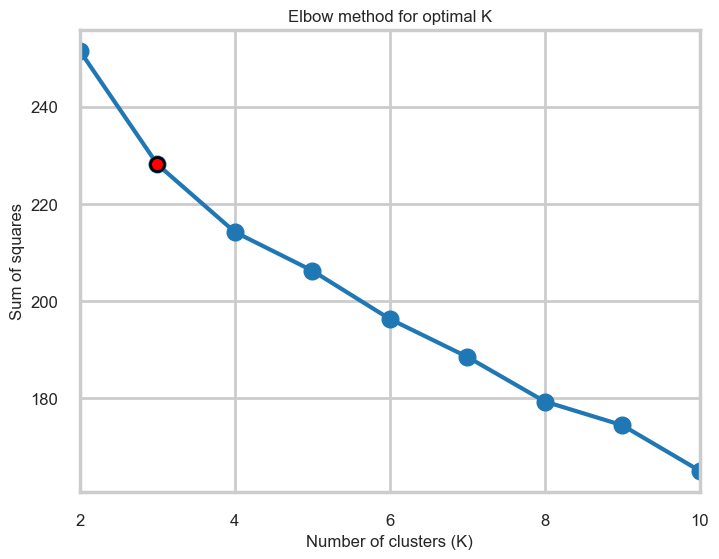

In [6]:
# Create a numpy matrix with only the columns representing the offers
x_cols = customer_df.to_numpy()

# Compute the sum of squared errors for each value of K
sse = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(x_cols)
    sse.append(kmeans.inertia_)

# Plot the sum of squared errors
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), sse, '-o')
plt.xlim(2, 10)
plt.xlabel('Number of clusters (K)', fontsize=12)
plt.ylabel('Sum of squares', fontsize=12)
plt.title('Elbow method for optimal K', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.scatter(3, sse[3 - 2], color='red', s=100, edgecolor='k', zorder=5)

plt.show()


Text(0.5, 1.0, 'Cluster sizes for K=3')

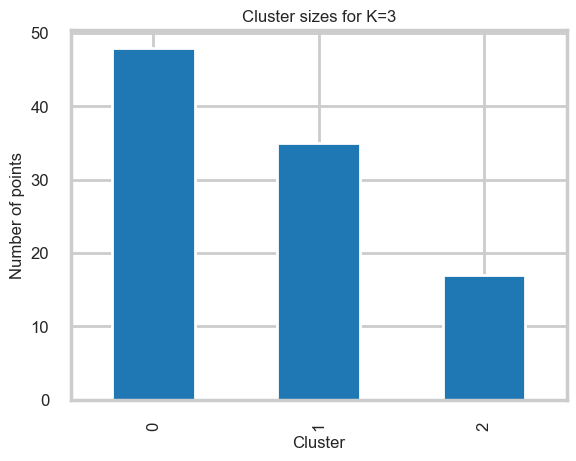

In [7]:
# Determine the best K from the elbow plot
best_k = 3

# Fit the KMeans model with the best K
kmeans = KMeans(n_clusters=best_k, n_init=10, random_state=42)
kmeans.fit(x_cols)

# Create a bar chart showing the number of points in each cluster
cluster_counts = pd.Series(kmeans.labels_).value_counts()
cluster_counts.plot(kind='bar')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Number of points', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(f'Cluster sizes for K={best_k}', fontsize=12)


#### 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

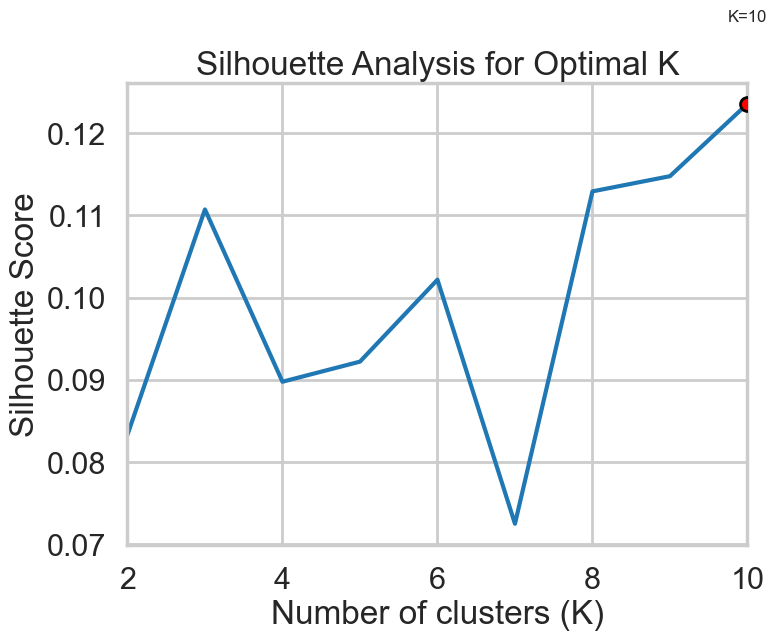

In [8]:
# Compute silhouette scores for different values of K
silhouette_scores = []
for k in range(2, 11):
    sil_kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    sil_kmeans.fit(x_cols)
    sil_labels = sil_kmeans.labels_
    sil_score = silhouette_score(x_cols, sil_labels)
    silhouette_scores.append(sil_score)

# Plot the silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores)
plt.xlim(2, 10)
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal K')

# Highest silhouette score at K=10 
plt.scatter(10, silhouette_scores[8], color='red', s=100, edgecolor='k', zorder=5)
plt.text(10, silhouette_scores[8] + 0.01, 'K=10', ha='center', fontsize=12)

plt.show()

#### 3aiii.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/). 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

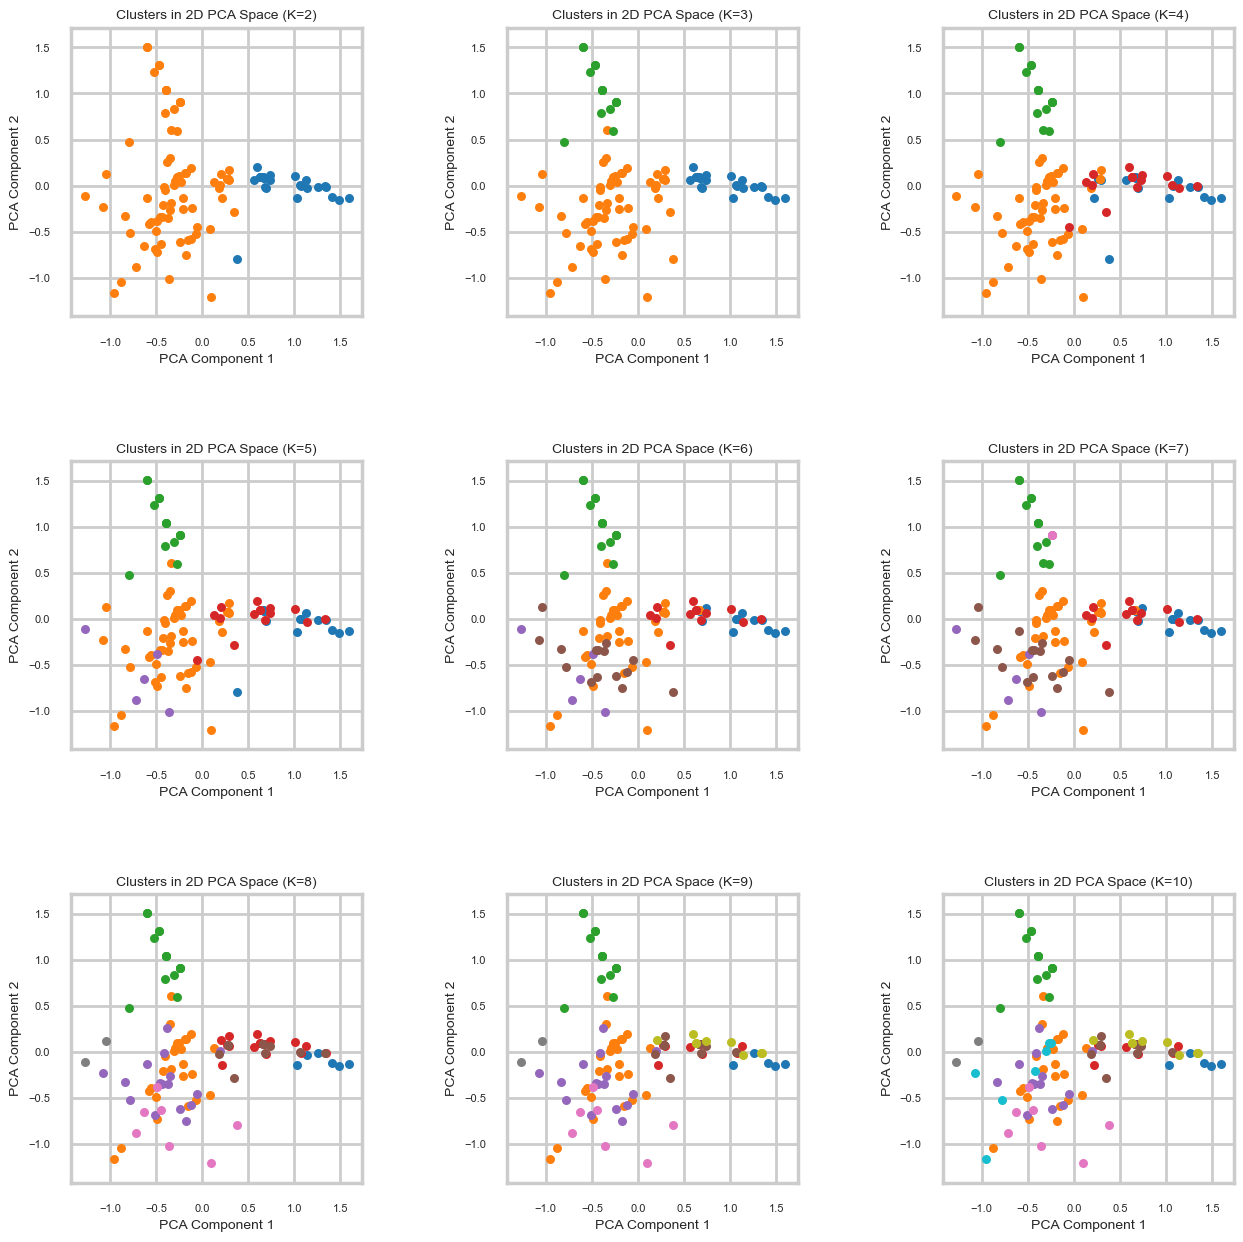

In [61]:
import pandas as pd  # Ensure pandas is imported

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_cols)

dfs = []

# Create a grid of 3x3 subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Iterate through K values from 2 to 10
for i, k in enumerate(range(2, 11)):
    row = i // 3
    col = i % 3
    
    # Fit KMeans with current K
    kmeans = KMeans(n_clusters=k, n_init="auto", random_state=42)
    cluster_labels = kmeans.fit_predict(x_cols)
    
    # Create DataFrame for PCA results and clustering labels, including 'k'
    pca_df = pd.DataFrame({
        'customer_name': customer_names,
        'cluster': cluster_labels,
        'x': X_pca[:, 0],
        'y': X_pca[:, 1],
        'k': [k] * len(cluster_labels) 
    })
    
    # Append the DataFrame to the list
    dfs.append(pca_df)
    
    # Plot the PCA scatter plot
    plot_pca_clusters(axes[row, col], pca_df, f'Clusters in 2D PCA Space (K={k})')

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

# Concatenate all DataFrames in the list into a single DataFrame
final_df = pd.concat(dfs, ignore_index=True)

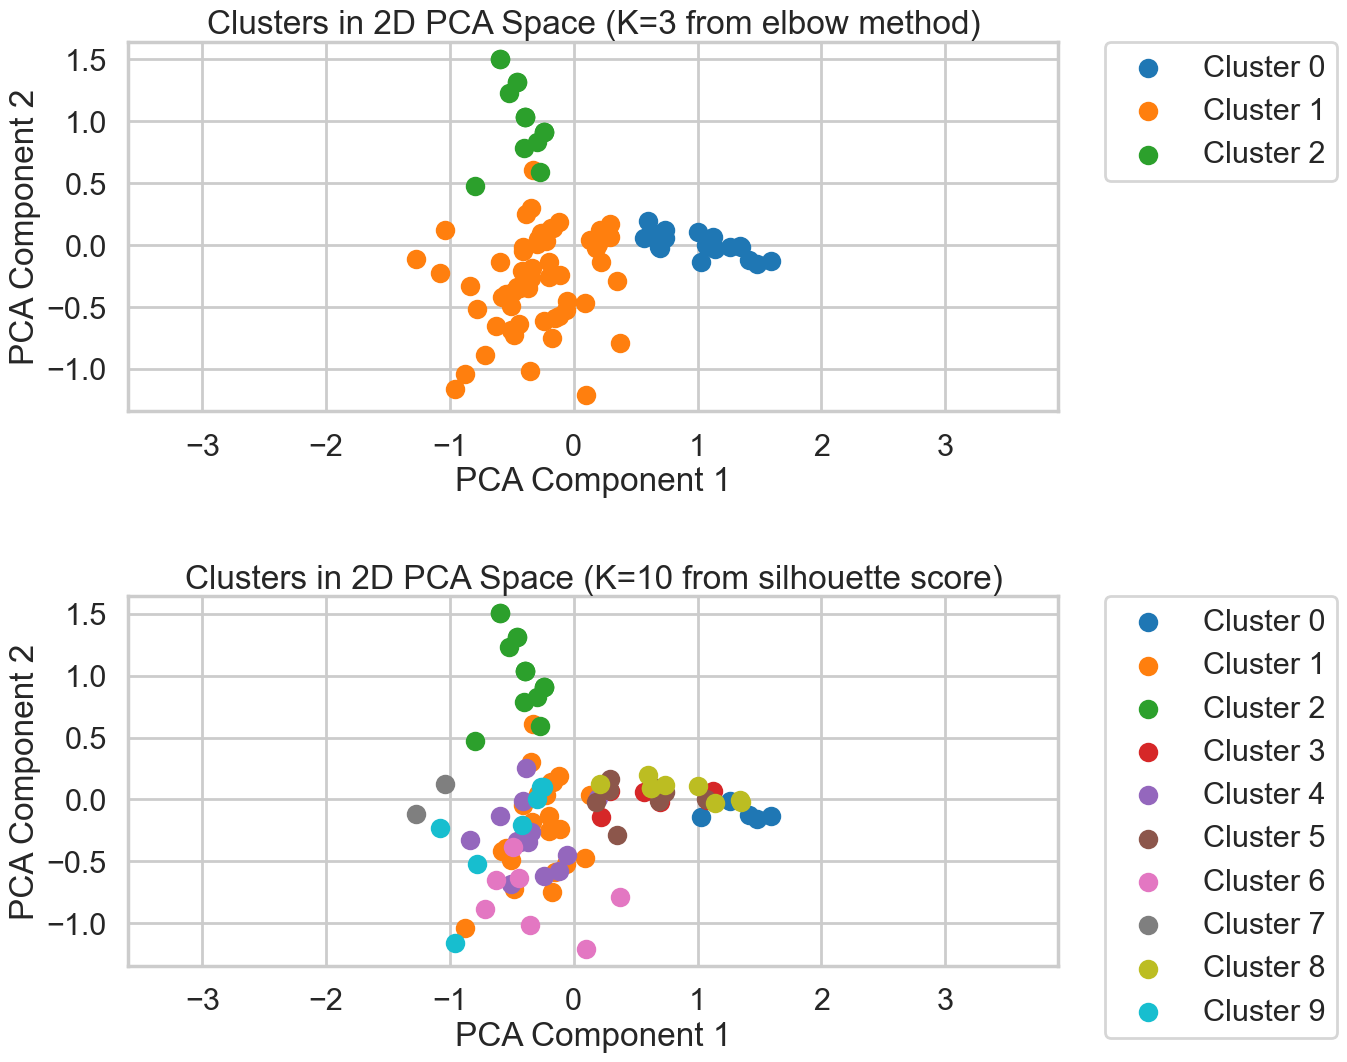

In [9]:
# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_cols)

# Initialize KMeans with the best K from elbow plot and silhouette score
best_k_elbow = 3
best_k_sil = 10

# Fit KMeans for K=3
kmeans_elbow = KMeans(n_clusters=best_k_elbow, n_init="auto", random_state=42)
cluster_labels_elbow = kmeans_elbow.fit_predict(x_cols)

# Fit KMeans for K=10
kmeans_sil = KMeans(n_clusters=best_k_sil, n_init="auto", random_state=42)
cluster_labels_sil = kmeans_sil.fit_predict(x_cols)

# Create DataFrames for PCA results and clustering labels
customer_names = customer_df.index.tolist()
pca_df_elbow = pd.DataFrame({
    'customer_name': customer_names,
    'cluster': cluster_labels_elbow,
    'x': X_pca[:, 0],
    'y': X_pca[:, 1]
})

pca_df_sil = pd.DataFrame({
    'customer_name': customer_names,
    'cluster': cluster_labels_sil,
    'x': X_pca[:, 0],
    'y': X_pca[:, 1]
})

# Create subplots for K=3 and K=10
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Define a function to plot PCA scatter plots
def plot_pca_clusters(ax, pca_df, title):
    # Sort the clusters for ordered plotting
    sorted_clusters = sorted(pca_df['cluster'].unique())
    for cluster in sorted_clusters:
        cluster_data = pca_df[pca_df['cluster'] == cluster]
        ax.scatter(cluster_data['x'], cluster_data['y'], label=f'Cluster {cluster}')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_title(title)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    # Set the same scale for both axes
    ax.axis('equal')

# Plot for K=3
plot_pca_clusters(axes[0], pca_df_elbow, 'Clusters in 2D PCA Space (K=3 from elbow method)')

# Plot for K=10
plot_pca_clusters(axes[1], pca_df_sil, 'Clusters in 2D PCA Space (K=10 from silhouette score)')

plt.subplots_adjust(hspace=0.5)
plt.show()

## Comparison of K=3 (elbow) and K=10 (silhouette) PCA Clustering Plots

K=3 clusters from the elbow method provided the most coherent and interpretable segmentation in the reduced 2D space. The clusters in this 2D subspace exhibit clear separation and minimal overlap, suggesting that the underlying customer segments have distinct characteristics that are well-captured by 2 principal components. 

On the other hand, when K=10 (determined by the silhouette method), the clusters in the 2D space appear messy and overlapping. This indicates that the additional clusters introduced by the higher K value may be capturing more granular or noise-like variations in the customer data that are not well-represented by just 2 components. In higher dimensions, these additional clusters might be more separable, but their projection onto the 2D subspace results in a less interpretable and less meaningful segmentation.

In [36]:
customer_clusters = pca_df_elbow.merge(customer_df, left_on='customer_name', right_index=True).drop('customer_name', axis=1)
customer_clusters.head()

,cluster,x,y,1,2,3,4,5,6,7,...,23,24,25,26,27,28,29,30,31,32
0,0,1.007580,0.108215,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,1,-0.287539,0.044715,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,2,-0.392032,1.038391,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,0,0.699477,-0.022542,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,1,0.088183,-0.471695,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [37]:
# Standardize the features in customer_clusters
scaler = StandardScaler()
customer_clusters_scaled = customer_clusters.copy()

# Convert all column names to strings
customer_clusters_scaled.columns = customer_clusters_scaled.columns.astype(str)

# Standardize all columns except 'cluster'
customer_clusters_scaled[customer_clusters_scaled.columns.drop('cluster')] = scaler.fit_transform(customer_clusters_scaled[customer_clusters_scaled.columns.drop('cluster')])

# Verify the standardization
customer_clusters_scaled.drop('cluster', axis=1).describe()


,x,y,1,2,3,4,5,6,7,8,...,23,24,25,26,27,28,29,30,31,32
count,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,100.000000,...,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
mean,3.108624e-17,1.998401e-17,-7.327472e-17,-5.995204e-17,2.331468e-17,5.995204e-17,-1.720846e-17,7.993606e-17,-4.996004e-17,0.000000,...,5.551115e-19,6.217249e-17,9.992007e-18,-1.887379e-17,-8.326673e-18,4.884981e-17,-1.887379e-17,1.998401e-17,-4.440892e-17,-7.993606e-17
std,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038,...,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00,1.005038e+00
min,-2.001051e+00,-2.189964e+00,-3.333333e-01,-3.333333e-01,-2.526456e-01,-3.692745e-01,-2.041241e-01,-3.692745e-01,-4.843221e-01,-0.500000,...,-2.294157e-01,-3.692745e-01,-2.526456e-01,-4.200840e-01,-3.144855e-01,-2.526456e-01,-4.525696e-01,-5.310850e-01,-4.525696e-01,-2.041241e-01
25%,-6.622737e-01,-5.998326e-01,-3.333333e-01,-3.333333e-01,-2.526456e-01,-3.692745e-01,-2.041241e-01,-3.692745e-01,-4.843221e-01,-0.500000,...,-2.294157e-01,-3.692745e-01,-2.526456e-01,-4.200840e-01,-3.144855e-01,-2.526456e-01,-4.525696e-01,-5.310850e-01,-4.525696e-01,-2.041241e-01
50%,-3.370374e-01,-1.419024e-02,-3.333333e-01,-3.333333e-01,-2.526456e-01,-3.692745e-01,-2.041241e-01,-3.692745e-01,-4.843221e-01,-0.500000,...,-2.294157e-01,-3.692745e-01,-2.526456e-01,-4.200840e-01,-3.144855e-01,-2.526456e-01,-4.525696e-01,-5.310850e-01,-4.525696e-01,-2.041241e-01
75%,5.561572e-01,2.154719e-01,-3.333333e-01,-3.333333e-01,-2.526456e-01,-3.692745e-01,-2.041241e-01,-3.692745e-01,-4.843221e-01,-0.500000,...,-2.294157e-01,-3.692745e-01,-2.526456e-01,-4.200840e-01,-3.144855e-01,-2.526456e-01,-4.525696e-01,-5.310850e-01,-4.525696e-01,-2.041241e-01
max,2.501739e+00,2.730259e+00,3.000000e+00,3.000000e+00,3.958114e+00,2.708013e+00,4.898979e+00,2.708013e+00,2.064742e+00,2.000000,...,4.358899e+00,2.708013e+00,3.958114e+00,2.380476e+00,3.179797e+00,3.958114e+00,2.209605e+00,1.882938e+00,2.209605e+00,4.898979e+00


In [134]:
# Merge df_offers and df_transactions based on offer_id
merged_df = pd.merge(df_offers, df_transactions, on='offer_id', how='inner')

# Join customers DataFrame with merged_df
customers = pca_df_elbow[['customer_name', 'cluster']]
offer_clusters_df = merged_df.merge(customers, left_on='customer_name', right_on='customer_name', how='left')
offer_clusters_df = offer_clusters_df.drop(['offer_id', 'customer_name'], axis=1)
offer_clusters_df

,campaign,varietal,min_qty,discount,origin,past_peak,cluster
0,January,Malbec,72,56,France,False,1
1,January,Malbec,72,56,France,False,1
2,January,Malbec,72,56,France,False,1
3,January,Malbec,72,56,France,False,2
4,January,Malbec,72,56,France,False,1
...,...,...,...,...,...,...,...
319,December,Champagne,72,89,France,False,1
320,December,Cabernet Sauvignon,72,45,Germany,True,1
321,December,Cabernet Sauvignon,72,45,Germany,True,1
322,December,Cabernet Sauvignon,72,45,Germany,True,1


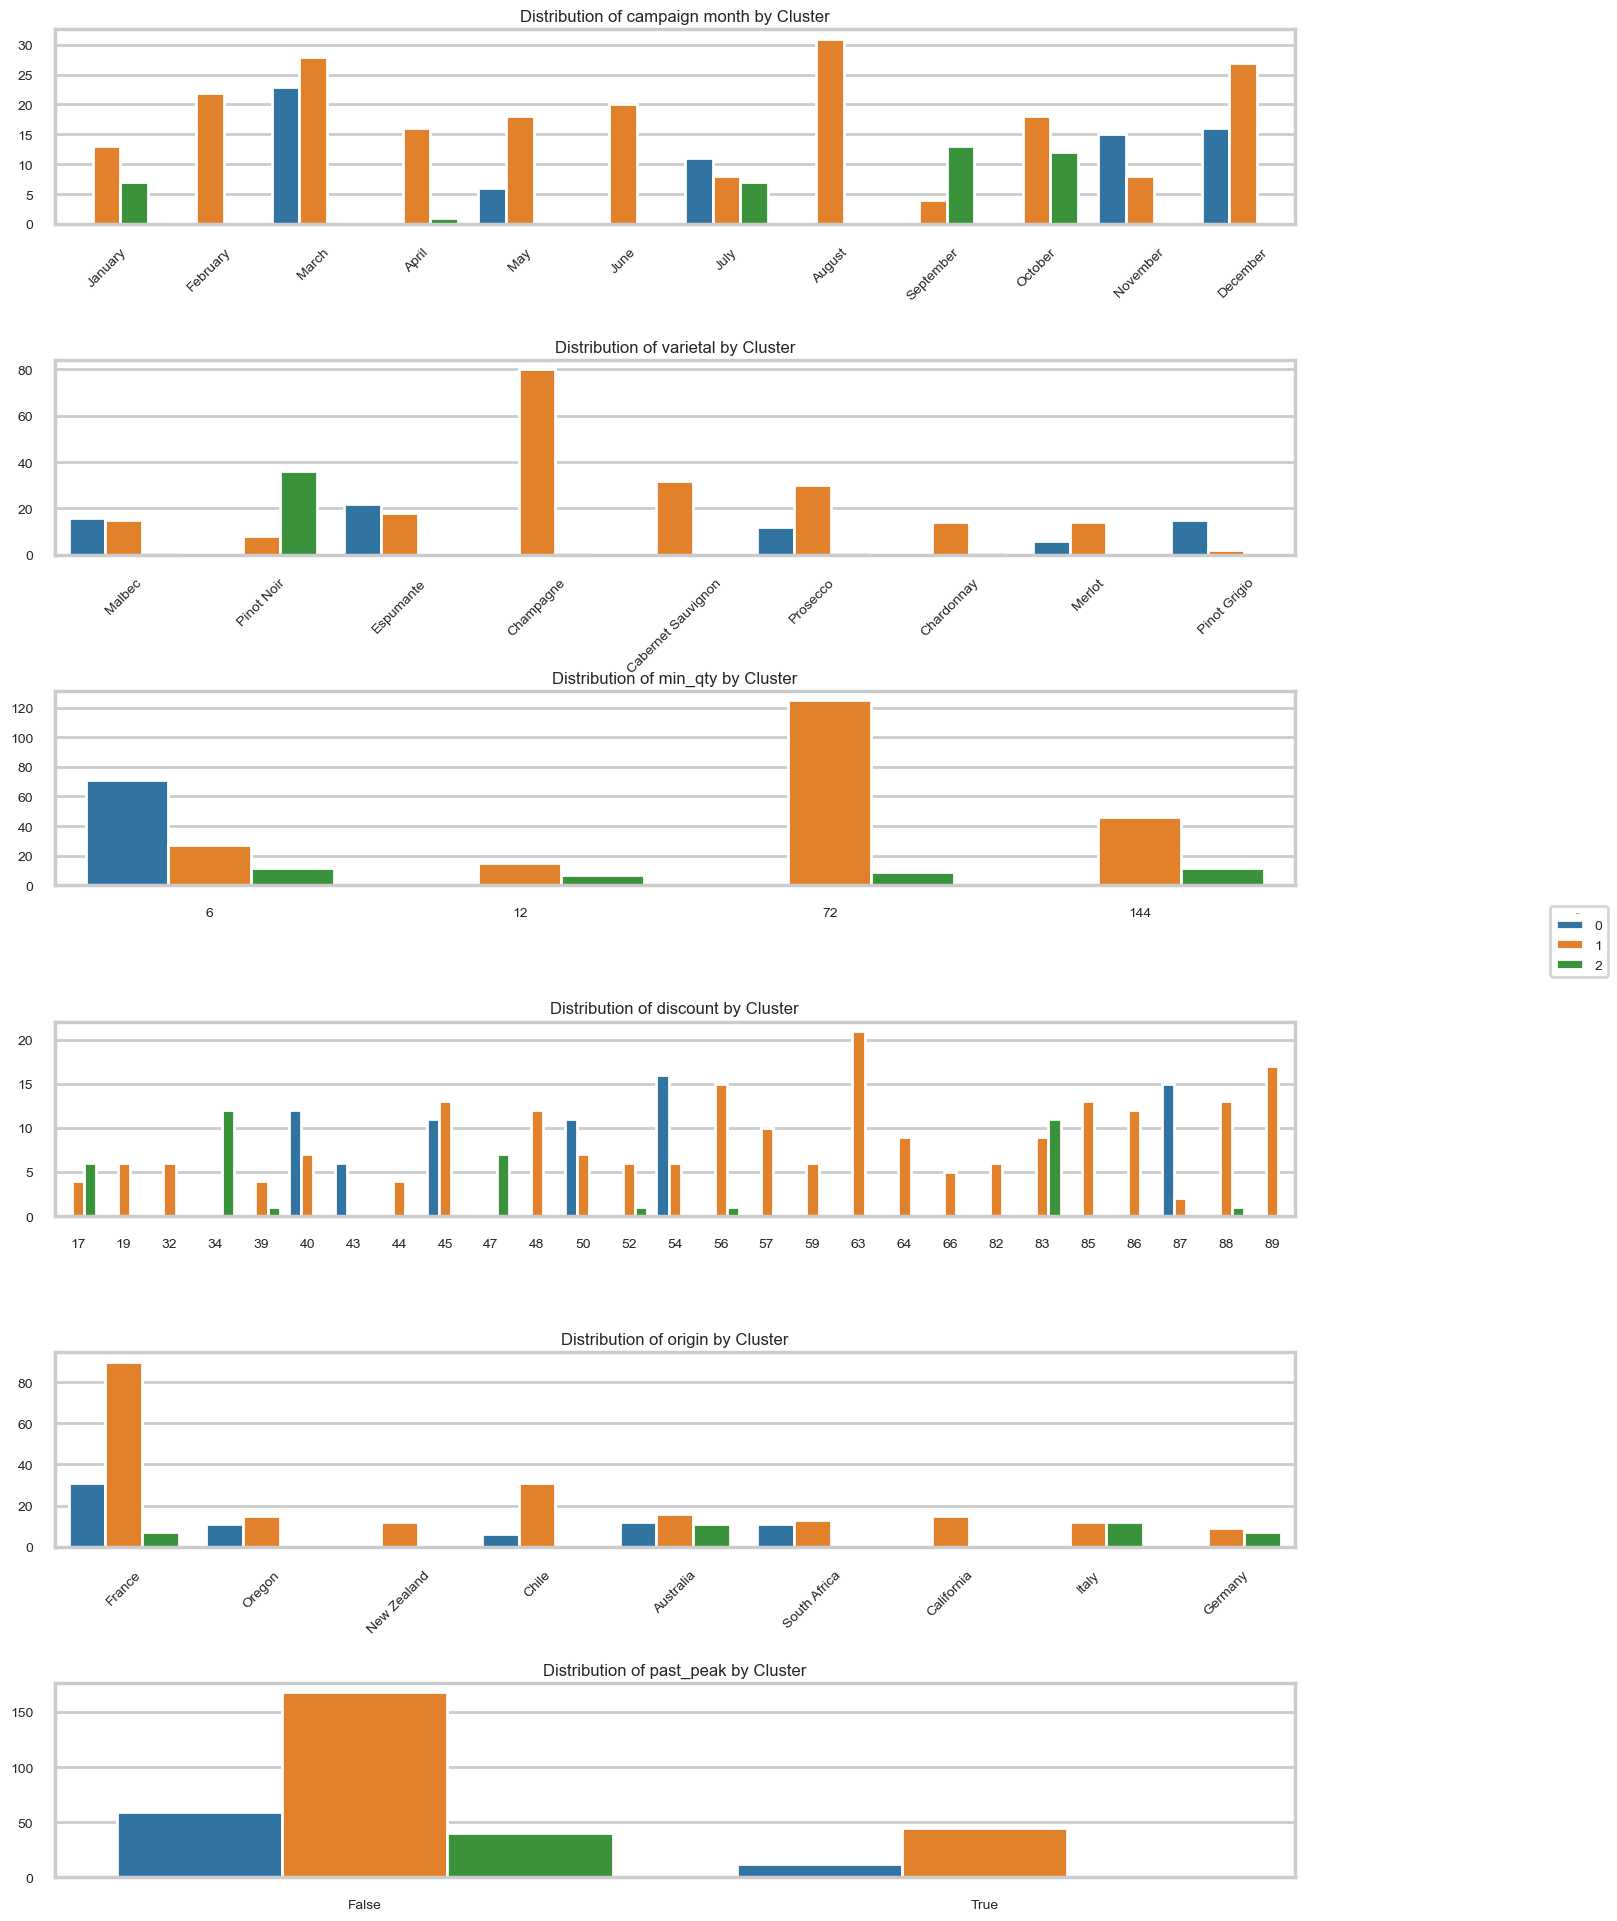

In [114]:
# Create a figure with subplots
fig, axes = plt.subplots(6, 1, figsize=(16, 24))

# Plot the distribution of campaign month by cluster
sns.countplot(x='campaign', hue='cluster', data=offer_clusters_df, ax=axes[0])
axes[0].set_title('Distribution of campaign month by Cluster', fontsize=12)
axes[0].tick_params(axis='x', rotation=45, labelsize=10)
axes[0].tick_params(axis='y', labelsize=10)  
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].legend_.remove()

# Plot the distribution of varietal by cluster
sns.countplot(x='varietal', hue='cluster', data=offer_clusters_df, ax=axes[1])
axes[1].set_title('Distribution of varietal by Cluster', fontsize=12)
axes[1].tick_params(axis='x', rotation=45, labelsize=10)
axes[1].tick_params(axis='y', labelsize=10)  
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].legend_.remove()

# Plot the distribution of min_qty by cluster
sns.countplot(x='min_qty', hue='cluster', data=offer_clusters_df, ax=axes[2])
axes[2].set_title('Distribution of min_qty by Cluster', fontsize=12)
axes[2].tick_params(labelsize=10)
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].legend_.remove()

# Plot the distribution of discount by cluster
sns.countplot(x='discount', hue='cluster', data=offer_clusters_df, ax=axes[3])
axes[3].set_title('Distribution of discount by Cluster', fontsize=12)
axes[3].tick_params(labelsize=10)
axes[3].set_xlabel('')
axes[3].set_ylabel('')
axes[3].legend_.remove()

# Plot the distribution of origin by cluster
sns.countplot(x='origin', hue='cluster', data=offer_clusters_df, ax=axes[4])
axes[4].set_title('Distribution of origin by Cluster', fontsize=12)
axes[4].tick_params(axis='x', rotation=45, labelsize=10)
axes[4].tick_params(axis='y', labelsize=10)  
axes[4].set_xlabel('')
axes[4].set_ylabel('')
axes[4].legend_.remove()

# Plot the distribution of past_peak by cluster
sns.countplot(x='past_peak', hue='cluster', data=offer_clusters_df, ax=axes[5])
axes[5].set_title('Distribution of past_peak by Cluster', fontsize=12)
axes[5].tick_params(labelsize=10)
axes[5].set_xlabel('')
axes[5].set_ylabel('')
axes[5].legend_.remove()

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.7)

# Create a single legend for all subplots with smaller font size
lines, labels = axes[0].get_legend_handles_labels()
fig.legend(lines, labels, loc='center right', bbox_to_anchor=(1.1, 0.5), title="Clusters", fontsize=10, title_fontsize=1)

plt.show()


### Cluster 1: The Champagne Enthusiasts
Cluster 1 stands out as the group of customers who consistently redeem offers throughout the year, regardless of the month. What sets them apart is their strong affinity for champagne. This cluster shows a notable preference for offers featuring champagne, surpassing the other clusters by a significant margin. Additionally, Cluster 1 tends to favor offers with a minimum quantity of 72 units and is attracted to substantial discounts. These customers are willing to purchase large quantities when presented with attractive deals.

### Cluster 2: The Pinot Noir Aficionados
In contrast to Cluster 1, Cluster 2 exhibits a marked preference for Pinot Noir. While this cluster redeems the least number of offers compared to the other two, they display a balanced distribution across different minimum quantity ranges. Interestingly, Cluster 2 exclusively redeems offers for wines that are not past their peak, indicating a discerning palate and a focus on quality. These customers also show a preference for wines originating from France, Australia, Italy, and Germany.

### Cluster 0: The Frugal Connoisseurs
Cluster 0 emerges as the most cost-conscious group. These customers are more selective in their purchases and tend to redeem offers with a low minimum quantity of 6 units. They also gravitate towards offers with the lowest median discount of 50, compared to Cluster 2 at 47 and Cluster 1 at 63. This suggests that Cluster 0 customers are more budget-minded and seek value in their wine purchases. Despite their frugality, they have a preference for wines from France, Chile, Australia, and South Africa.

### Commonalities and Distinctions
While each cluster exhibits distinct preferences, there are some commonalities worth noting. All three clusters show a higher propensity to redeem offers for wines that are not past their peak. Additionally, Clusters 0 and 1 both favor offers featuring wines from France, highlighting the enduring appeal of French wines across different customer segments.

However, the clusters diverge in their purchasing habits and preferences. Cluster 1 stands out for their enthusiasm for champagne and willingness to purchase large quantities with substantial discounts at a constant rate throughout the year. Cluster 2, on the other hand, is more focused on Pinot Noir and prioritizes quality over quantity. Cluster 0 distinguishes itself as the most price-sensitive group, seeking value and lower minimum quantities in their purchases.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

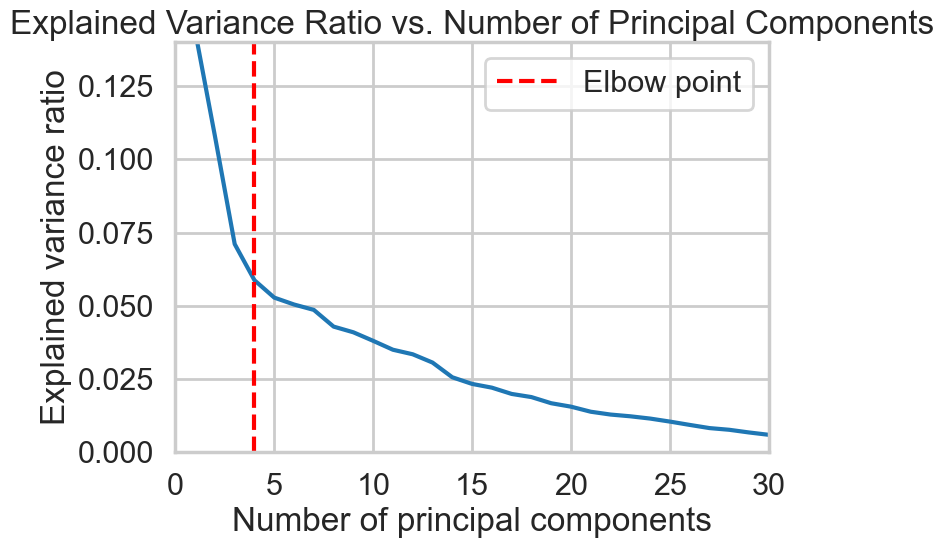

In [125]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
X_pca = pca.fit(x_cols)

# Plot the explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.xlabel('Number of principal components')
plt.ylabel('Explained variance ratio')
plt.title('Explained Variance Ratio vs. Number of Principal Components')
plt.axvline(x=4, color='r', linestyle='--', label='Elbow point')
plt.legend()
plt.xlim(0,30)
plt.ylim(0,.14)
plt.tight_layout()
plt.show()


## 4. Conclusions and next steps
### 4a. Conclusions
What can you conclude from your investigations? Make a note, formulate it as clearly as possible, and be prepared to discuss it with your mentor in your next call.

The elbow plot appears to be the most reliable approach for determining the optimal number of clusters or principal components. The optimal value of K should be driven both by domain knowledge/theory and by the data. By integrating the original offer data with the cluster assignments and principal components, we can gain a deeper understanding of the unique characteristics of each cluster and how the various dimensions contribute to the overall data structure. While PCA is a powerful tool for dimensionality reduction, it does have the potential to make the data more challenging to interpret. 

As an alternative, I wonder if it might be more insightful to cluster the data based on the dummy-coded offer features, rather than the dummy-coded offer IDs. This approach would allow the clusters to form based on the specific details of each offer, enabling us to more directly uncover what each customer segment prefers in terms of offer characteristics.

For instance, if certain offers featuring champagne are only available with a low minimum quantity, clustering on the offer features would help us discern whether the cluster that favors champagne offers is drawn to the champagne itself or the low minimum quantity. This level of granular insight could pave the way for more personalized offer recommendations and targeted marketing strategies.

### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [148]:
# Count the number of offers per customer
n_offers = merged_df.groupby('customer_name').size().reset_index(name='n_offers')

# Create dummy variables for min_qty
min_qty_dummies = pd.get_dummies(merged_df['min_qty'], prefix='min_qty')

# Create dummy variables for discount
discount_dummies = pd.get_dummies(merged_df['discount'], prefix='discount')

# Create dummy variables for all other categorical columns except 'customer_name' and 'offer_id'
other_dummies = pd.get_dummies(merged_df.drop(['customer_name', 'offer_id', 'min_qty', 'discount'], axis=1))

# Combine all the dummy variables
dummies = pd.concat([min_qty_dummies, discount_dummies, other_dummies], axis=1)

# Add the 'customer_name' column back to the DataFrame of dummies
dummies['customer_name'] = merged_df['customer_name']

# Group by 'customer_name' and sum the dummies to get the count of each category per customer
customer_dummies = dummies.groupby('customer_name').sum().reset_index()

# Merge the 'n_offers' column with the customer_dummies DataFrame
#customer_dummies = pd.merge(customer_dummies, n_offers, on='customer_name')

customer_dummies.head()

,customer_name,min_qty_6,min_qty_12,min_qty_72,min_qty_144,discount_17,discount_19,discount_32,discount_34,discount_39,...,varietal_Prosecco,origin_Australia,origin_California,origin_Chile,origin_France,origin_Germany,origin_Italy,origin_New Zealand,origin_Oregon,origin_South Africa
0,Adams,3,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,1,0
1,Allen,0,0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,Anderson,1,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0
3,Bailey,2,0,0,0,0,0,0,0,0,...,1,1,0,0,1,0,0,0,0,0
4,Baker,1,1,2,0,0,0,0,0,0,...,2,1,1,0,1,1,0,0,0,0


In [163]:
from sklearn.cluster import AffinityPropagation, SpectralClustering, AgglomerativeClustering, DBSCAN

X = customer_dummies.drop(['customer_name'], axis=1)

# Affinity Propagation
af = AffinityPropagation(random_state=42).fit(X)
af_clusters = pd.DataFrame({'customer_name': customer_dummies['customer_name'], 'af_cluster': af.labels_})
af_cluster_offers = merged_df.merge(af_clusters, left_on='customer_name', right_on='customer_name', how='left')
af_cluster_offers = af_cluster_offers.drop(['offer_id', 'customer_name'], axis=1)
print(f"Affinity Propagation: {len(np.unique(af.labels_))} clusters")

# Spectral Clustering
sc = SpectralClustering(n_clusters=3, random_state=42).fit(X)
sc_clusters = pd.DataFrame({'customer_name': customer_dummies['customer_name'], 'sc_cluster': sc.labels_})
sc_cluster_offers = merged_df.merge(sc_clusters, left_on='customer_name', right_on='customer_name', how='left')
sc_cluster_offers = sc_cluster_offers.drop(['offer_id', 'customer_name'], axis=1)
print(f"Spectral Clustering: {len(np.unique(sc.labels_))} clusters")

# Agglomerative Clustering
ac = AgglomerativeClustering(n_clusters=3).fit(X)
ac_clusters = pd.DataFrame({'customer_name': customer_dummies['customer_name'], 'ac_cluster': ac.labels_})
ac_cluster_offers = merged_df.merge(ac_clusters, left_on='customer_name', right_on='customer_name', how='left')
ac_cluster_offers = ac_cluster_offers.drop(['offer_id', 'customer_name'], axis=1)
print(f"Agglomerative Clustering: {len(np.unique(ac.labels_))} clusters")

# DBSCAN
db = DBSCAN(eps=0.5, min_samples=3).fit(X)
db_clusters = pd.DataFrame({'customer_name': customer_dummies['customer_name'], 'db_cluster': db.labels_})
db_cluster_offers = merged_df.merge(db_clusters, left_on='customer_name', right_on='customer_name', how='left')
db_cluster_offers = db_cluster_offers.drop(['offer_id', 'customer_name'], axis=1)
print(f"DBSCAN: {len(np.unique(db.labels_))} clusters")



Affinity Propagation: 14 clusters
Spectral Clustering: 3 clusters
Agglomerative Clustering: 3 clusters
DBSCAN: 4 clusters


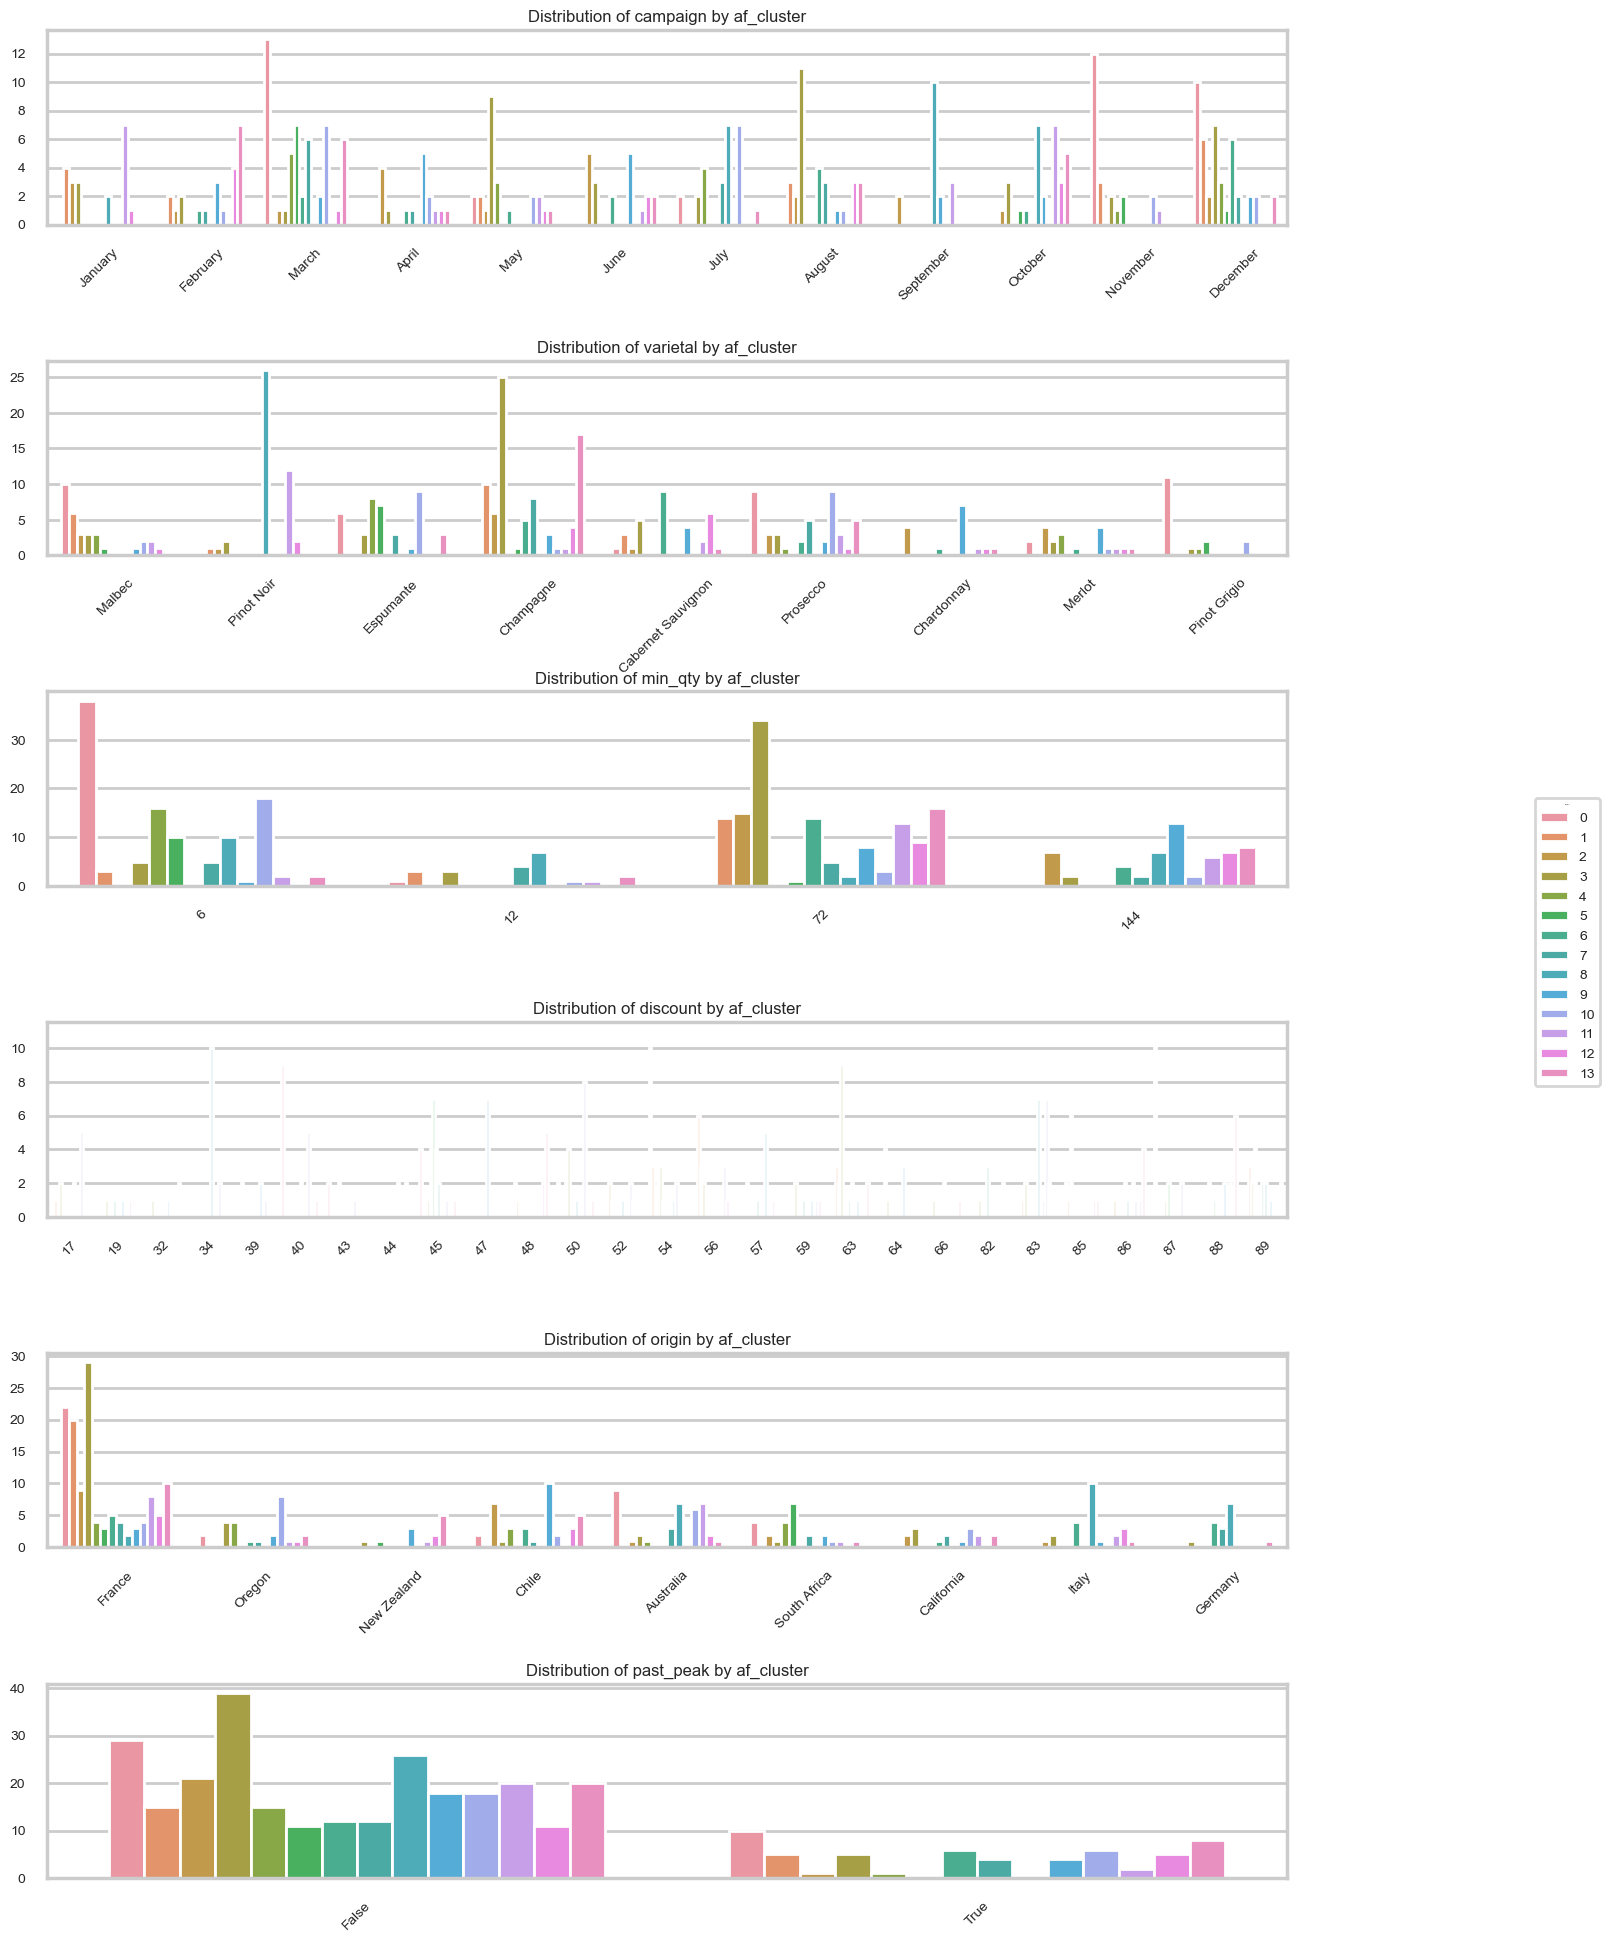

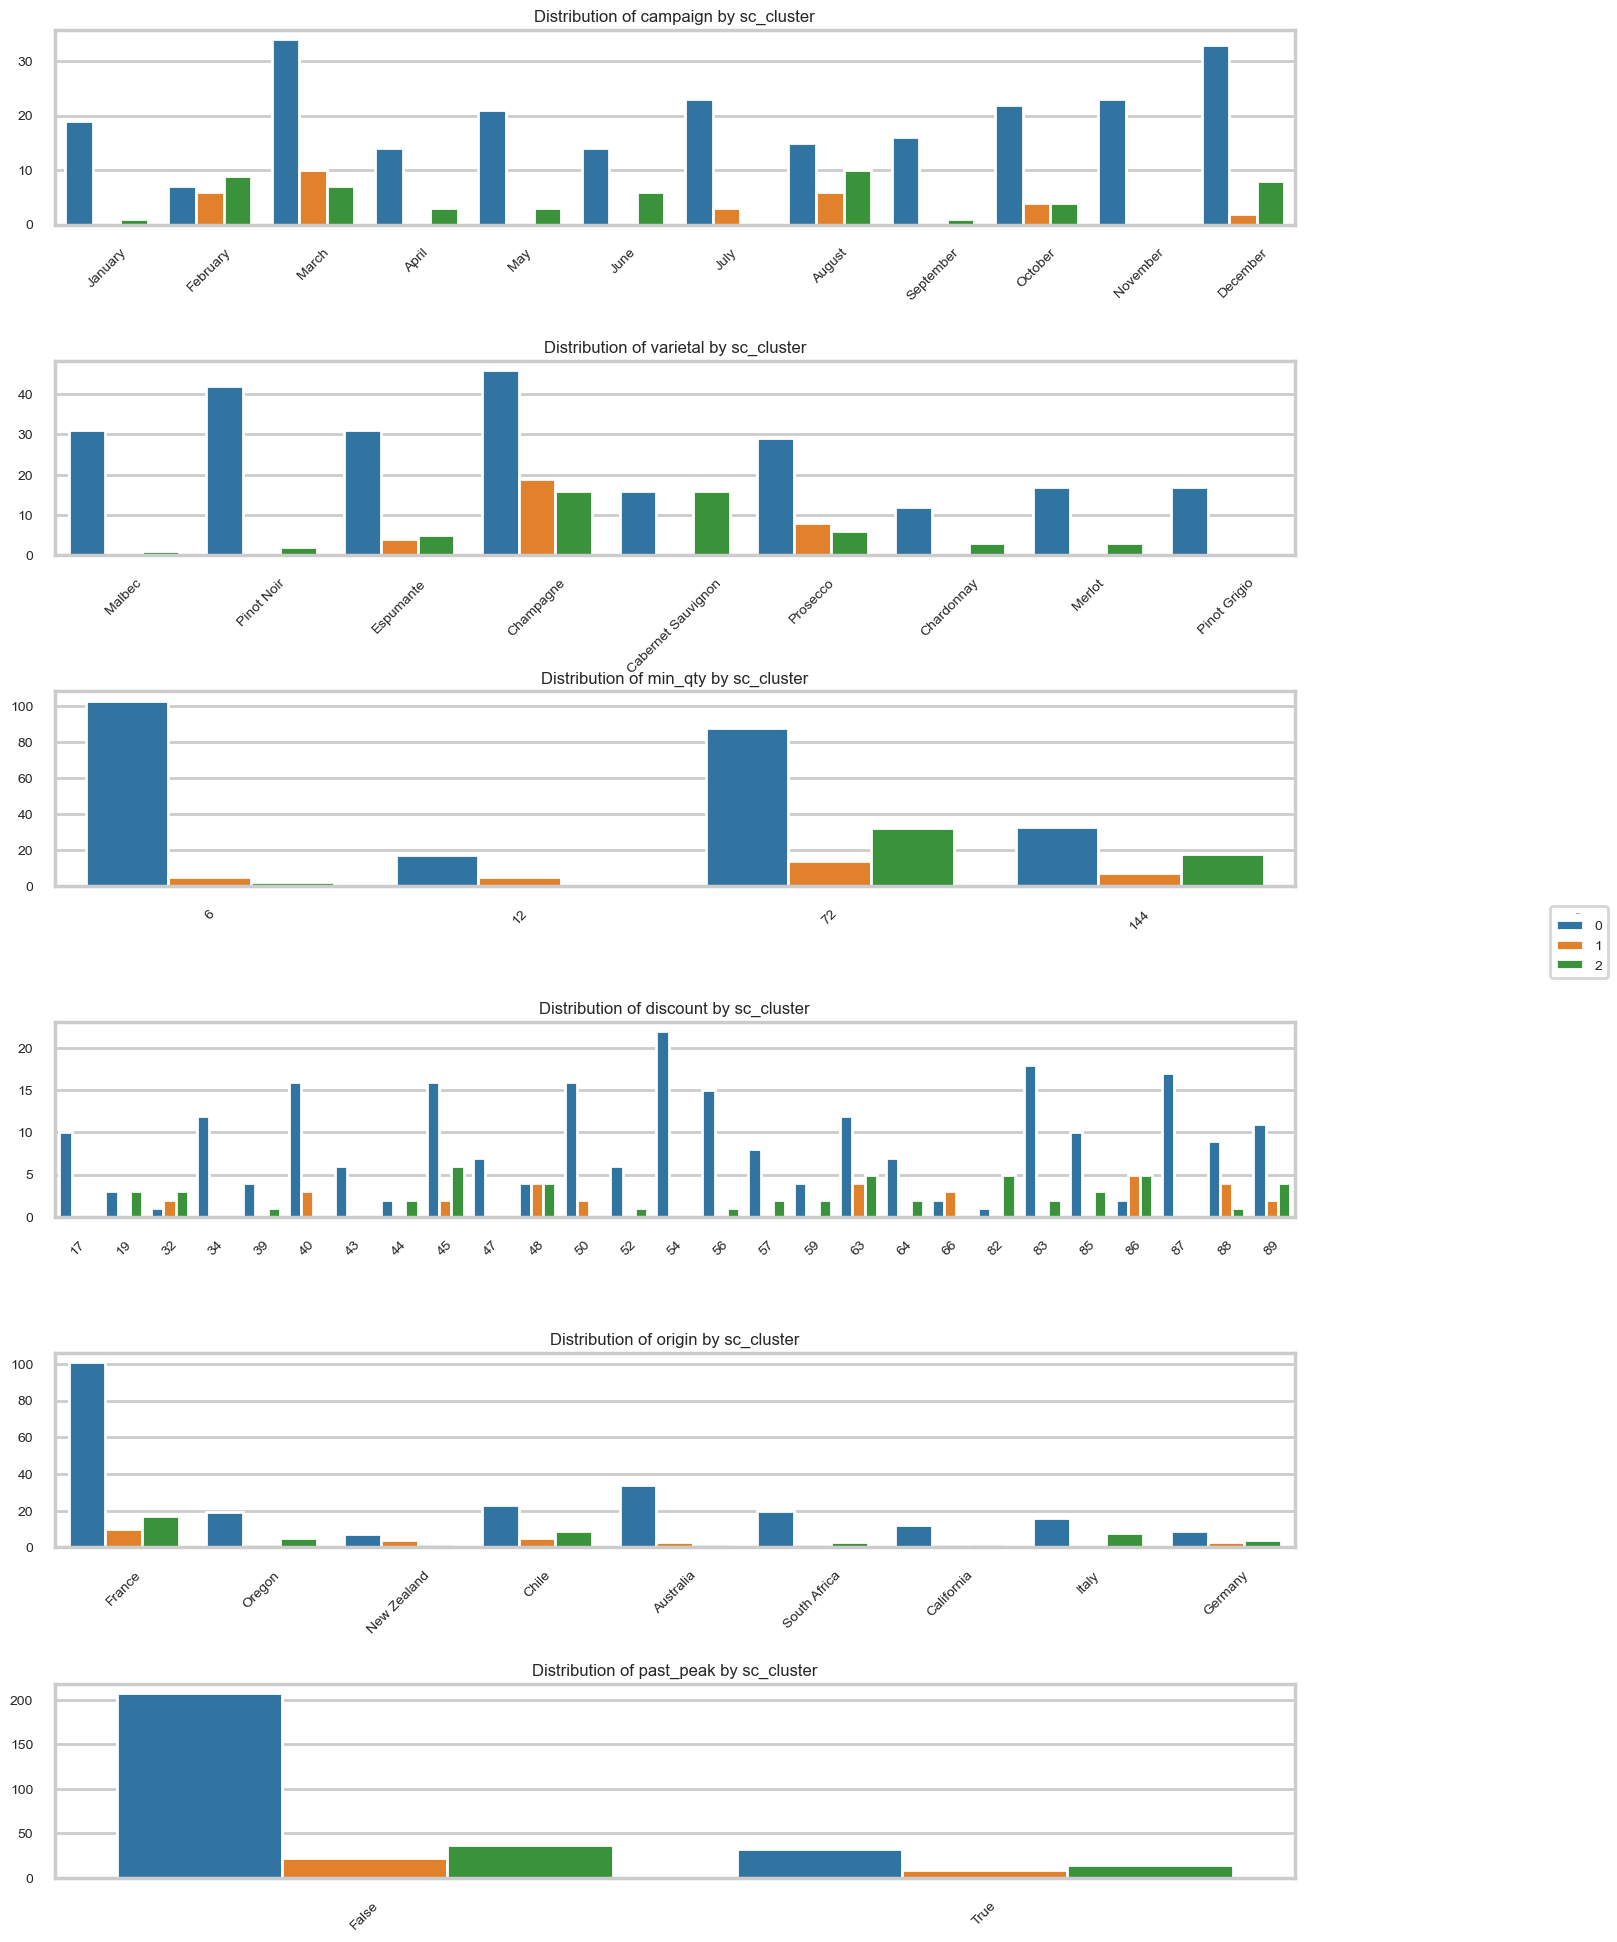

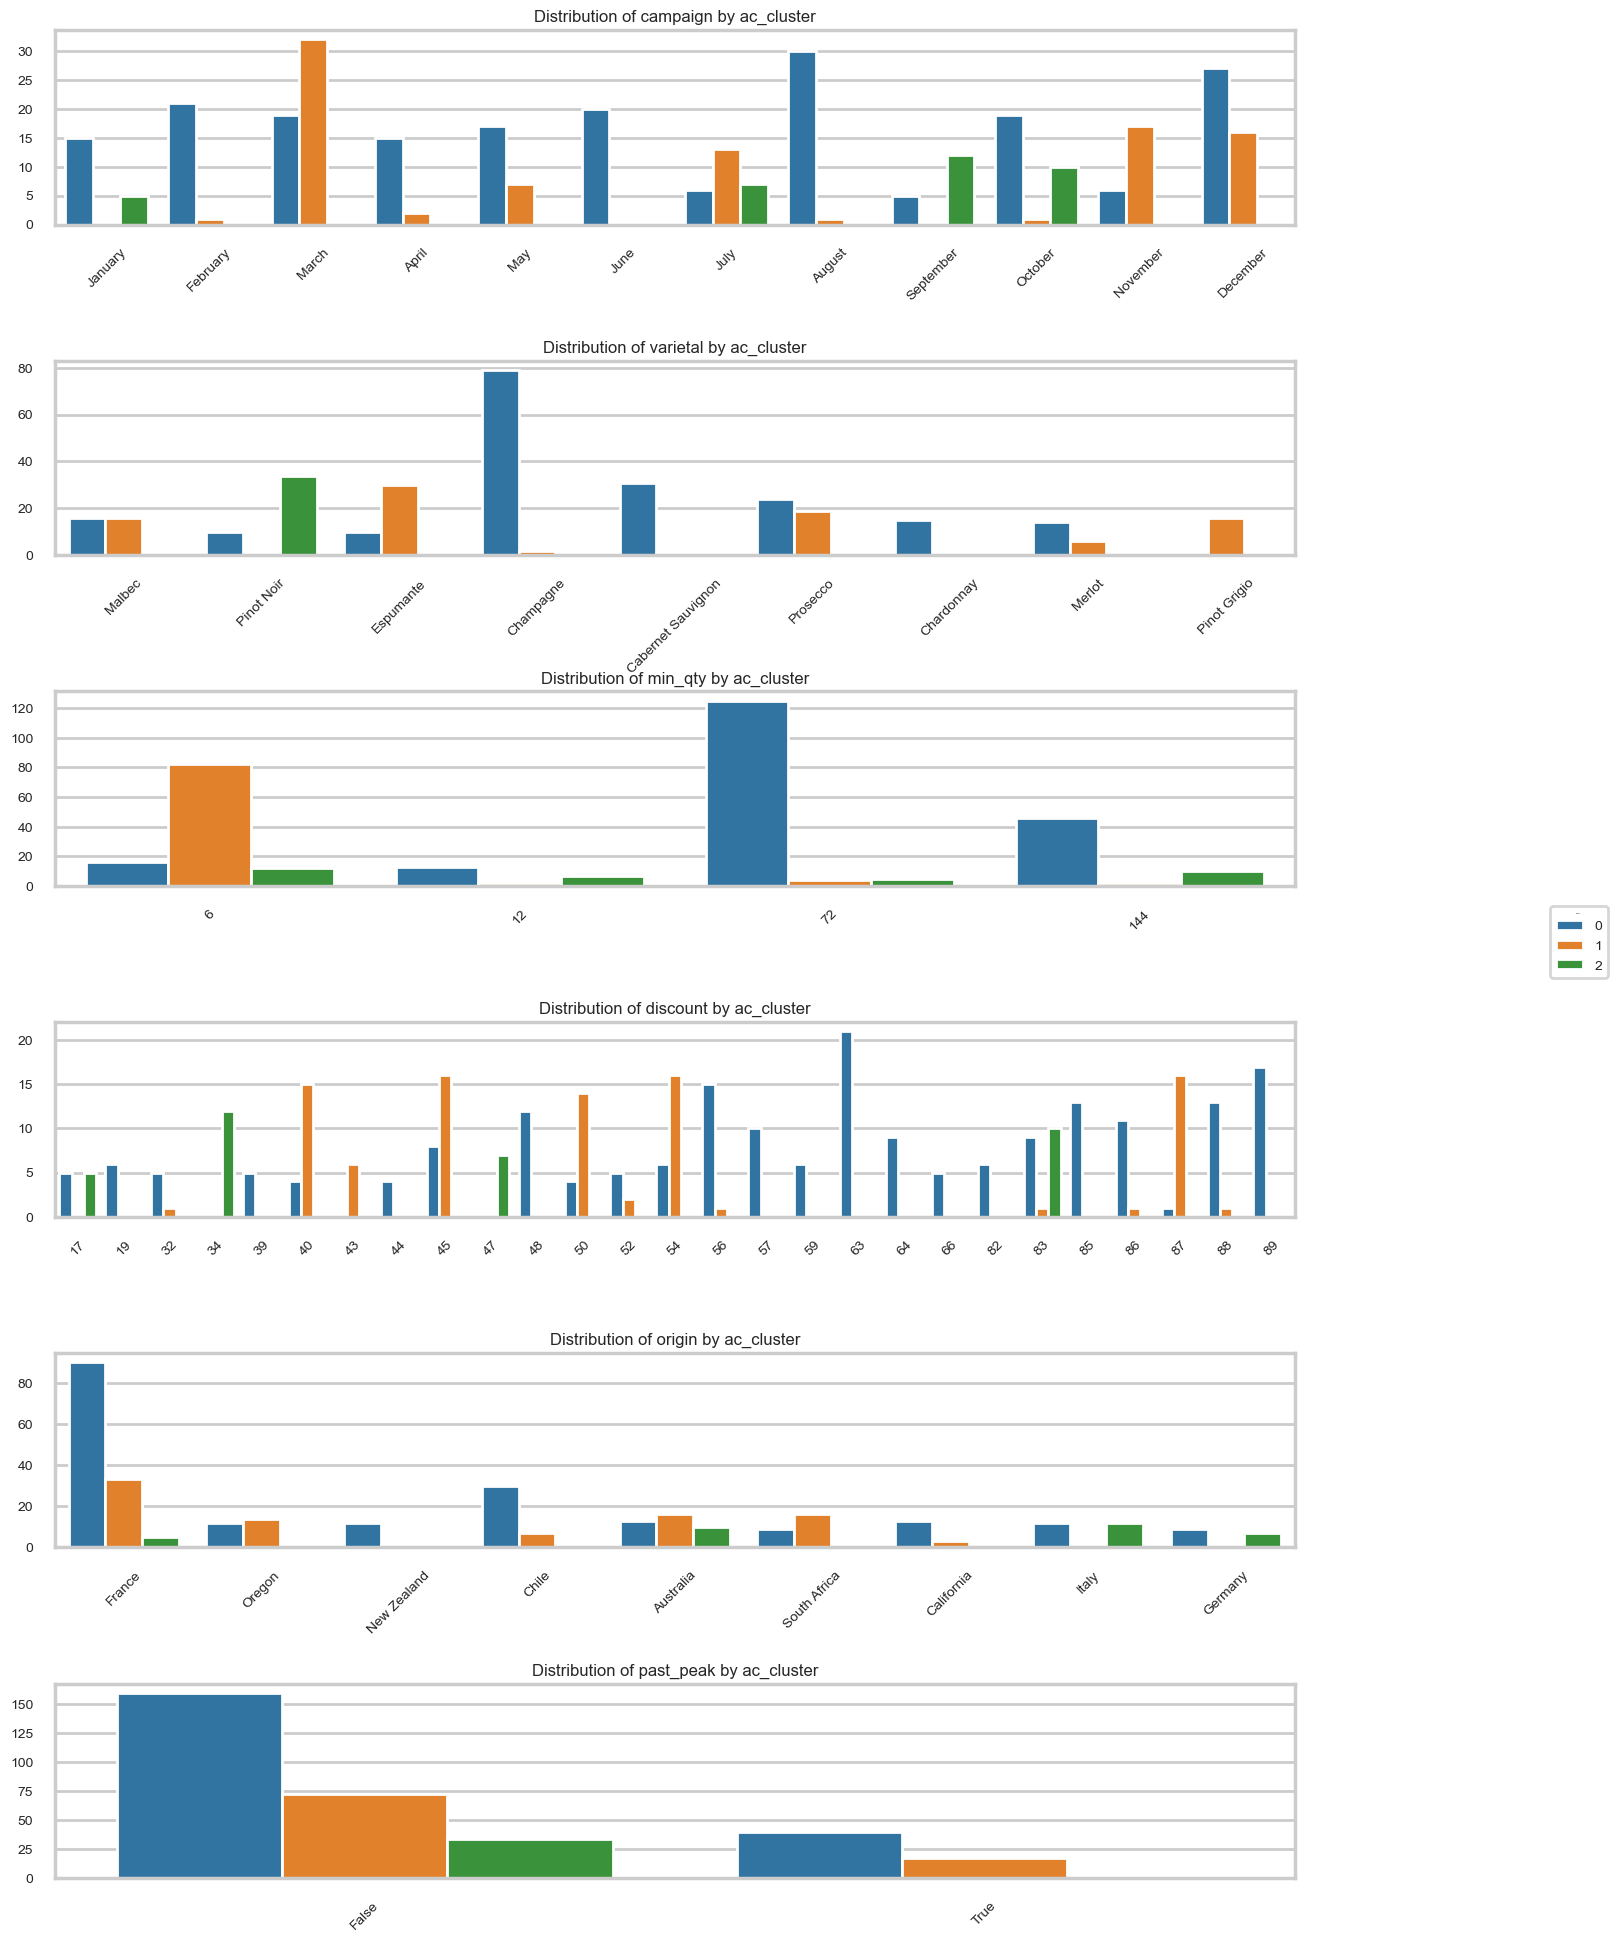

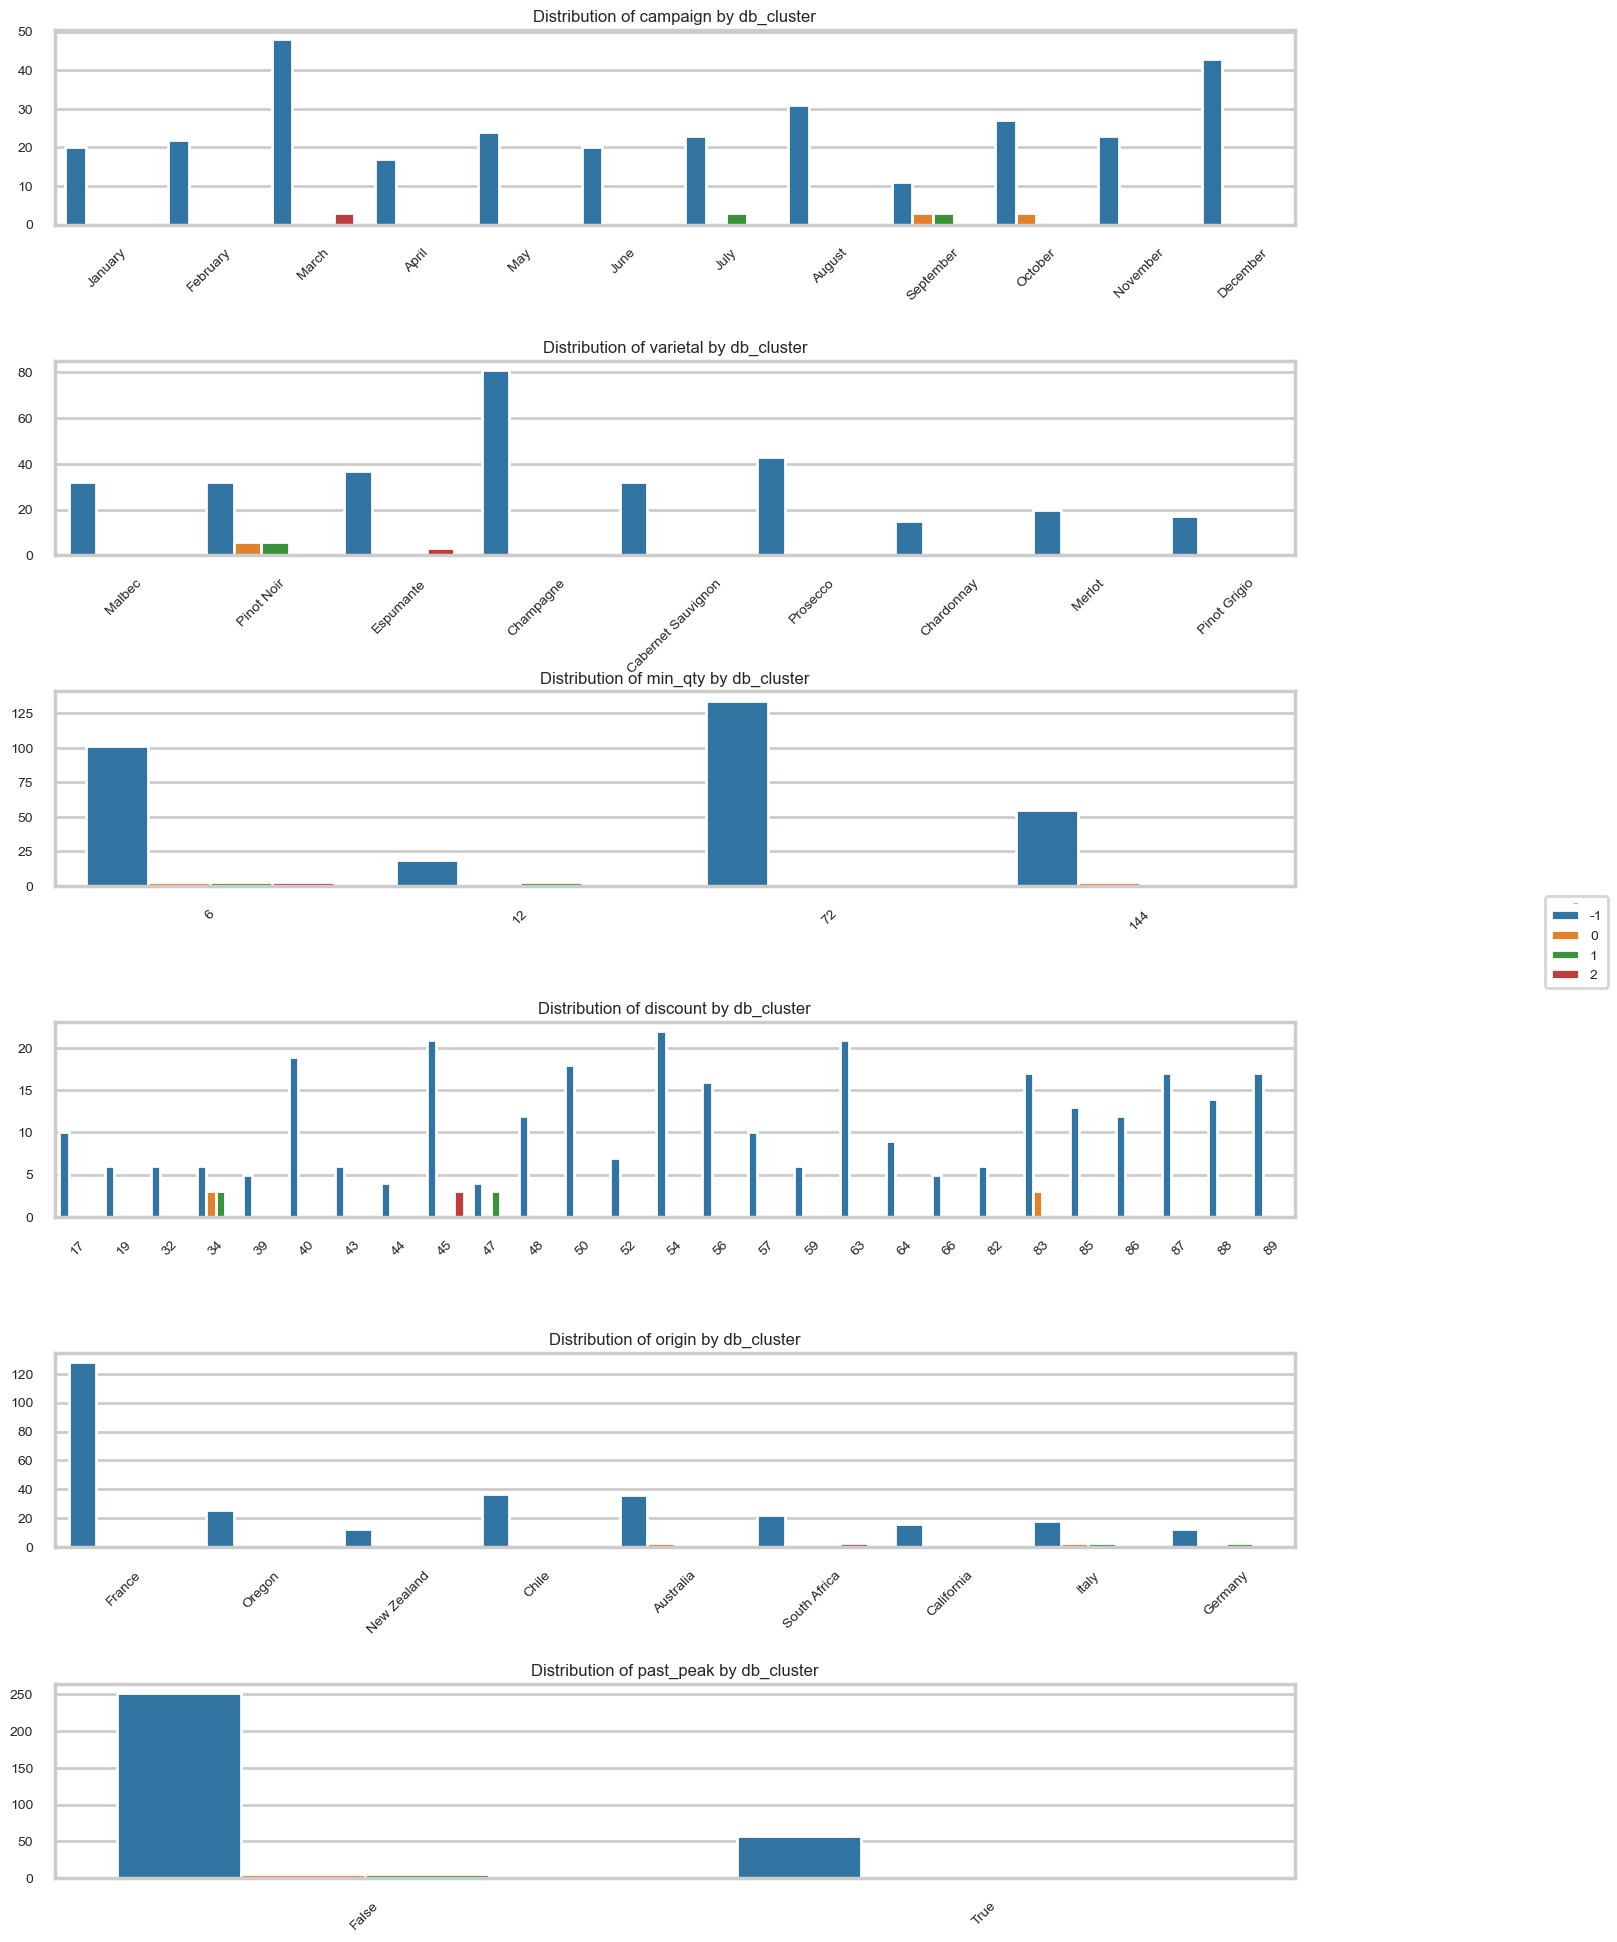

In [164]:
def plot_cluster_distributions(df, cluster_col, features):
    # Create a figure with subplots
    fig, axes = plt.subplots(len(features), 1, figsize=(16, 24))

    # Loop through the features and plot the cluster distributions
    for i, feature in enumerate(features):
        sns.countplot(x=feature, hue=cluster_col, data=df, ax=axes[i])
        axes[i].set_title(f'Distribution of {feature} by {cluster_col}', fontsize=12)
        axes[i].tick_params(axis='x', rotation=45, labelsize=10)
        axes[i].tick_params(axis='y', labelsize=10)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
        axes[i].legend_.remove()

    # Adjust the spacing between subplots
    plt.subplots_adjust(hspace=0.7)

    # Create a single legend for all subplots with smaller font size
    lines, labels = axes[0].get_legend_handles_labels()
    fig.legend(lines, labels, loc='center right', bbox_to_anchor=(1.1, 0.5), title="Clusters", fontsize=10, title_fontsize=1)

    plt.show()

# Plot the cluster distributions for each algorithm
plot_cluster_distributions(af_cluster_offers, 'af_cluster', ['campaign', 'varietal', 'min_qty', 'discount', 'origin', 'past_peak'])
plot_cluster_distributions(sc_cluster_offers, 'sc_cluster', ['campaign', 'varietal', 'min_qty', 'discount', 'origin', 'past_peak'])
plot_cluster_distributions(ac_cluster_offers, 'ac_cluster', ['campaign', 'varietal', 'min_qty', 'discount', 'origin', 'past_peak'])
plot_cluster_distributions(db_cluster_offers, 'db_cluster', ['campaign', 'varietal', 'min_qty', 'discount', 'origin', 'past_peak'])